### A lo largo de este notebook se van a ver distintos ejemplos de uso de Spark ML, tocando un poco la parte de análisis exploratorio e integración con Pandas y Matplotlib, para posteriormente ajustar un algoritmo de aprendizaje automático. El conjunto de datos corresponde al dataset Adult de UCI, donde se proporciona una muestra de individuos con diferentes atributos y se trata de predecir si su salario está por encima o por debajo de 50.000 dólares al año. Para esta práctica se pide un sólo ejercicio: extender el ejemplo de ajuste de aprendizaje automático para poder seleccionar el hiperparámetro de regularización óptimo, de cara a obtener un mejor rendimiento del clasificador. Se sugiere emplear la funcionalidad de búsqueda grid que tiene Spark ML y que podéis encontrar en las transparencias de clase.

In [140]:
%matplotlib inline

In [141]:
df = sqlContext.\
    read.format("com.databricks.spark.csv").\
    option("header", "true").\
    option("inferschema", "true").\
    option("mode", "DROPMALFORMED").\
    load("adult.csv").\
    cache()
columnas = df.columns
print(columnas)

['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'target']


In [142]:
df.select("workclass").groupBy("workclass").count().show()

+-----------------+-----+
|        workclass|count|
+-----------------+-----+
|        State-gov| 1298|
|      Federal-gov|  960|
| Self-emp-not-inc| 2541|
|        Local-gov| 2093|
|          Private|22696|
|                ?| 1836|
|     Self-emp-inc| 1116|
|      Without-pay|   14|
|     Never-worked|    7|
+-----------------+-----+



In [143]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: integer (nullable = true)
 |-- capital_loss: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- native_country: string (nullable = true)
 |-- target: boolean (nullable = true)



### De las columnas 0 a 5 hacemos un resumen simple de las que son numéricas (según el esquema deducido)

In [144]:
df.select(*(df.columns[i] for i in range(0,6))).describe().show() # sólo columnas numéricas

+-------+------------------+------------------+-----------------+
|summary|               age|            fnlwgt|    education_num|
+-------+------------------+------------------+-----------------+
|  count|             32561|             32561|            32561|
|   mean| 38.58164675532078|189778.36651208502| 10.0806793403151|
| stddev|13.640432553581356|105549.97769702227|2.572720332067397|
|    min|                17|             12285|                1|
|    max|                90|           1484705|               16|
+-------+------------------+------------------+-----------------+



### Limpieza de datos

#### Primero quitamos todas las columnas que tienen valores perdidos o que son constantes (un solo valor)

In [145]:
from pyspark.sql.types import StringType 
columnsToDrop = []
for x in df.schema.fields:
    condicion = ""
    if(str(x.dataType) == "StringType"):
        condicion = " = ''"        
    else:
        condicion = " is null"
    
    cuenta = df.select(x.name).where( x.name + condicion ).count()
    if(cuenta > 0):
        print(x.name + "(" + str(x.dataType) + "): " + str(cuenta))
        columnsToDrop.append(x.name)
    else: 
        cuenta_distintos = df.select(x.name).distinct().count()
        if(cuenta_distintos == 1):  # Quitamos columnas constantes (con un solo valor)
            print("[ " + x.name + " : distintos = " + str(cuenta_distintos) + "]")
            columnsToDrop.append(x.name)

In [146]:
columnsToKeep = list(x for x in df.columns if x not in columnsToDrop)
df = df.select(columnsToKeep).cache()

#### Ahora quitamos edades mayores de 35 y nos centramos en jóvenes

In [147]:
print("Número de filas totales: " + str(df.count()))
# Renombramos la columna target como "label" porque por un bug de Spark 1.5.2, la clase CrossValidator
# siempre busca una columna llamada "label" a pesar de que el Estimator tenga especificado otro nombre para el target
df = df.where("age < 35").withColumnRenamed("target", "label").cache()
print("Número de filas quitando edades mayores de 35: " + str(df.count()))

Número de filas totales: 32561
Número de filas quitando edades mayores de 35: 14049


### Histograma: Se calcula con Spark y el histograma calculado se trae a local como Pandas para pintarlo 

In [148]:
edadHist = df.select(['age']).rdd.flatMap(lambda x: x).histogram(50)

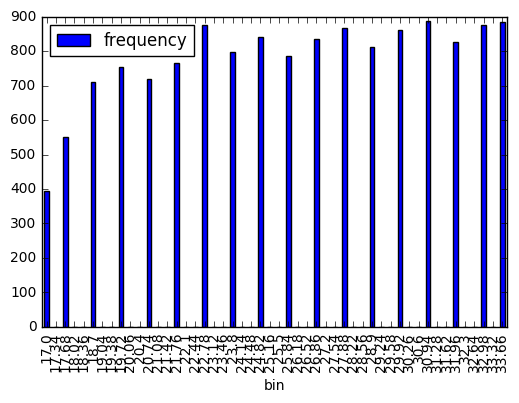

In [149]:
import pandas as pd
pd.DataFrame(list(zip(list(edadHist)[0], list(edadHist)[1])), columns=['bin','frequency']).\
             set_index('bin').plot(kind='bar')

In [150]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: integer (nullable = true)
 |-- capital_loss: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- native_country: string (nullable = true)
 |-- label: boolean (nullable = true)



### Donut Chart: Porcentaje de clientes que contrata cierto número de productos dental

#### Los porcentajes se calculan de manera distribuida y el resultado se trae al servidor de Jupyter para pintarlo

In [151]:
from pyspark.sql.functions import col, lit
numWorkDf = df.groupBy("workclass").count()
totalFilas = df.count()
numWorkDf2 = numWorkDf.\
                        withColumn("total", lit(totalFilas)).\
                        withColumn("porcentaje", col("count") / col("total"))
numWorkDfPd = numWorkDf2.toPandas()

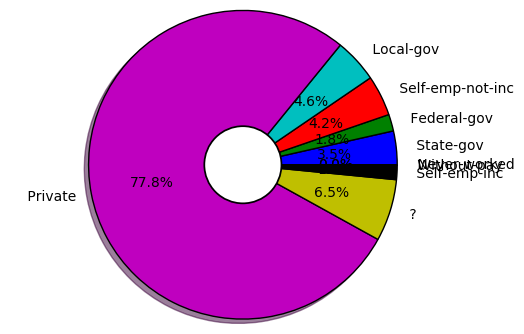

In [152]:
import matplotlib.pyplot as plt

# The slices will be ordered and plotted counter-clockwise.
labels = numWorkDfPd["workclass"]
sizes = numWorkDfPd["porcentaje"]
#colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
#explode = (0, 0, 0, 0)  # explode a slice if required

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
        
#draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.25,color='black', fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()  

### Regresión logística sobre la variable target usando regularización L1 con lambda = 0.002

In [153]:
df.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
| true|12561|
|false| 1488|
+-----+-----+



#### Convertir en enteros las variables categóricas (String) y pasar las features a una sola columna de tipo Vector

In [154]:
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

label = "label"
vectorizedFeatures = "myVectorizedFeatures"
columnasContinuas = list([x.name for x in df.schema.fields if x.name != label and x.dataType != StringType()])
columnasString = list([x.name for x in df.schema.fields if x.name != label and x.dataType == StringType()])
nombresIndexados = list([(x + "_indexed") for x in columnasString])
indexers = [StringIndexer(inputCol = x, outputCol = x + "_indexed") for x in columnasString]
pipeline = Pipeline(stages=indexers)

In [155]:
vecAssembler = VectorAssembler(inputCols=columnasContinuas+nombresIndexados, outputCol=vectorizedFeatures)

In [156]:
from pyspark.sql.types import DoubleType
assembledDf = vecAssembler.transform(pipeline.fit(df).transform(df)).\
                            select([vectorizedFeatures, label]).\
                            withColumn(label, col(label).cast(DoubleType())).cache()

In [157]:
assembledDf.select("myVectorizedFeatures").show(10);

+--------------------+
|myVectorizedFeatures|
+--------------------+
|[28.0,338409.0,13...|
|[31.0,45781.0,14....|
|[30.0,141297.0,13...|
|(14,[0,1,2,5,7,12...|
|(14,[0,1,2,5,7,9,...|
|[34.0,245487.0,4....|
|(14,[0,1,2,5,6,9]...|
|(14,[0,1,2,5,9,10...|
|(14,[0,1,2,5,9],[...|
|(14,[0,1,2,5,6,7,...|
+--------------------+
only showing top 10 rows



In [158]:
[training, test] = assembledDf.randomSplit([0.7, 0.3], seed = 123456)
training.cache()

DataFrame[myVectorizedFeatures: vector, label: double]

In [159]:
from pyspark.ml.classification import LogisticRegression
# parameter lambda = 0.002
# elastic net param alpha = 1.0 means using only L1 regularization and giving weight 0 to L2 regularization tem
lr = LogisticRegression().\
    setMaxIter(50).\
    setRegParam(0.02).\
    setElasticNetParam(1.0).\
    setLabelCol(label).\
    setFeaturesCol(vectorizedFeatures)
mymodel = lr.fit(training)

In [160]:
dfTrain = mymodel.transform(training).cache()

In [161]:
dfTest = mymodel.transform(test).cache()

In [162]:
predictionAndLabelsTrain = dfTrain.select([label, "prediction"]).rdd.map(lambda row: (row.prediction, row.label)).cache()

In [163]:
predictionAndLabelsTest = dfTest.select([label, "prediction"]).rdd.map(lambda row: (row.prediction, row.label)).cache()

In [164]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

def printMetrics(predictedDf, label):
    predictionAndLabels = predictedDf.select([label, "prediction"]).rdd.map(lambda row: (row.prediction, row.label)).cache()    
    # Instantiate metrics object
    metrics = BinaryClassificationMetrics(predictionAndLabels)
    # Area under precision-recall curve
    print("Area under PR = %s" % metrics.areaUnderPR)
    # Area under ROC curve
    print("Area under ROC = %s" % metrics.areaUnderROC)
    # Accuracy
    aciertos = predictedDf.where( label + " = prediction" ).count()
    ejemplos = predictedDf.count()
    print("Accuracy = %s " % (aciertos/ejemplos))

In [165]:
print("-------------------------------------------------------")
print("Medidas de rendimiento sobre los datos de ENTRENAMIENTO")
print("-------------------------------------------------------")
printMetrics(dfTrain, label)
print("-------------------------------------------------------")

-------------------------------------------------------
Medidas de rendimiento sobre los datos de ENTRENAMIENTO
-------------------------------------------------------
Area under PR = 0.949254772716
Area under ROC = 0.527841000781
Accuracy = 0 
-------------------------------------------------------


In [166]:
print("-------------------------------------------------------")
print("Medidas de rendimiento sobre los datos de PRUEBAS")
print("-------------------------------------------------------")
printMetrics(dfTest, label)
print("-------------------------------------------------------")

-------------------------------------------------------
Medidas de rendimiento sobre los datos de PRUEBAS
-------------------------------------------------------
Area under PR = 0.950418160096
Area under ROC = 0.525171624714
Accuracy = 0 
-------------------------------------------------------
